In [168]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [169]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [170]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [171]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:////Users/lauramitchellemagallanes/Downloads/sqlalchemy-challenge/Resources/hawaii.sqlite")

In [172]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

/var/folders/t7/zvqkqk0n15q14df5z_0hn3440000gn/T/ipykernel_43596/1895431338.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect=True)


In [173]:
# View all of the classes that automap found
base.classes.keys()

['station', 'measurement']

In [174]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [175]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [176]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date)).scalar()


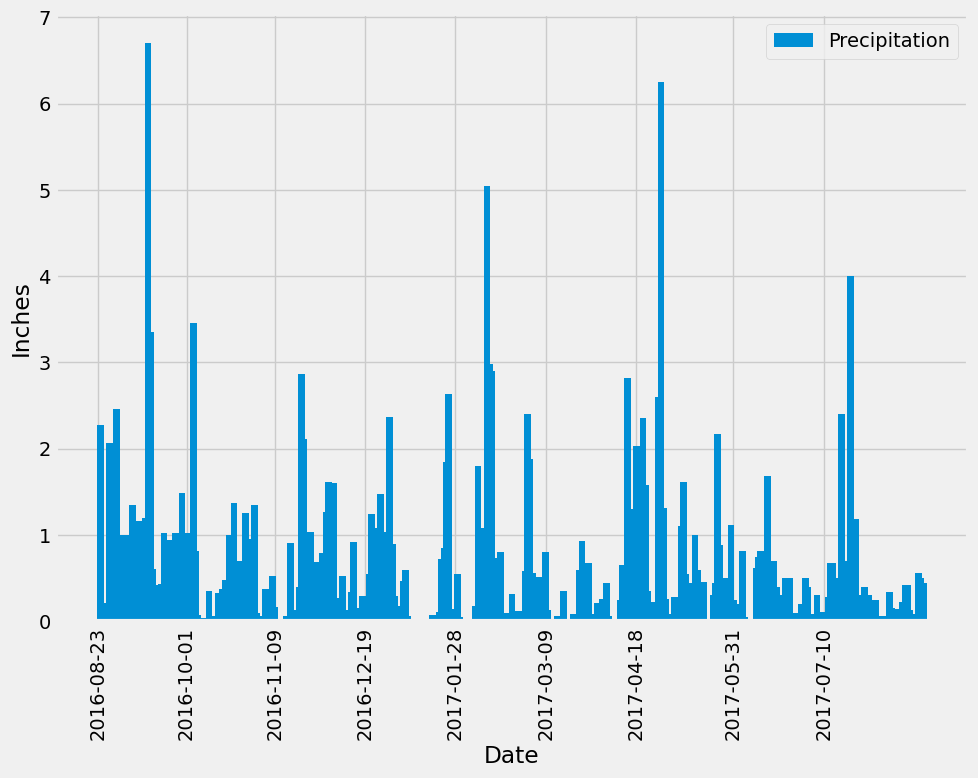

In [177]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date_data = dt.datetime.strptime(recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_date_data).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])


# Convert 'date' column to datetime
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

# Specific Dates
specific_dates = pd.to_datetime(['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', 
                                 '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', 
                                 '2017-07-10'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 8))  # Adjust the figure size
plt.bar(precipitation_df['date'], precipitation_df['precipitation'], label='Precipitation', width=3)
plt.xlabel('Date')
plt.ylabel('Inches')

# Set x-ticks and labels
plt.xticks(specific_dates, specific_dates.strftime('%Y-%m-%d'), rotation=90)

plt.legend()
plt.tight_layout()
plt.show()



In [178]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['precipitation'].describe()
print(precipitation_summary)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [179]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()


In [180]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations_query = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).\
    all()
active_stations_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [181]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'  
temperature_stats = session.query(
    func.min(measurement.tobs).label('min_temp'),
    func.max(measurement.tobs).label('max_temp'),
    func.avg(measurement.tobs).label('avg_temp')
).filter(measurement.station == most_active_station_id).all()

# Format the results as a list
results = [(temperature_stats[0].min_temp, temperature_stats[0].max_temp, temperature_stats[0].avg_temp)]

# Display the results
print(results)

[(54.0, 85.0, 71.66378066378067)]


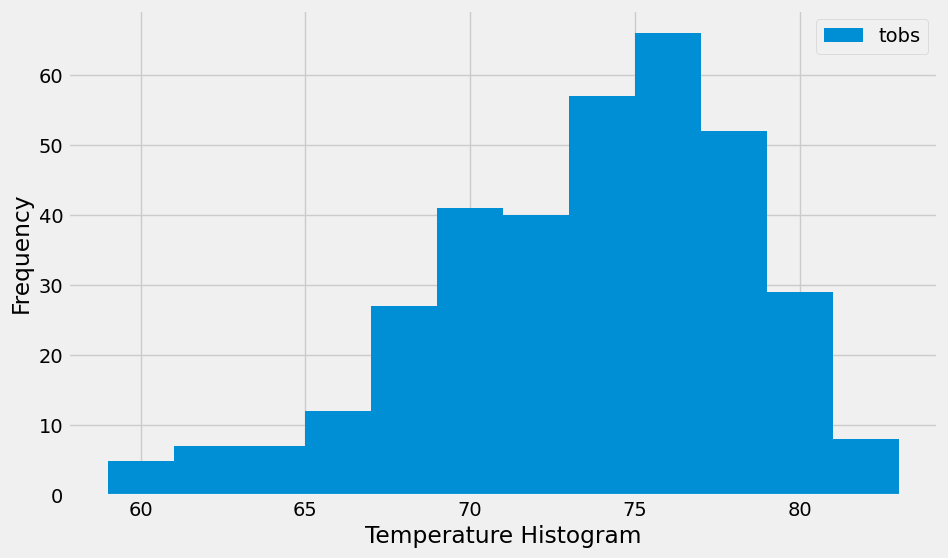

In [182]:
# Using the most active station id
latest_date = session.query(func.max(measurement.date)).scalar()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement.tobs).filter(
    measurement.station == most_active_station_id,
    measurement.date >= last_date_data).all()

# Convert the results to temperatures
temperature_list = [temp[0] for temp in temperature_data]

# Plot the temperature observations as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_list, bins=12, label='tobs')
plt.xlabel('Temperature Histogram')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Close Session

In [183]:
# Close Session
session.close()